In [2]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import distances
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from deeptime.util.data import TrajectoryDataset
from deeptime.util.torch import MLP
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import VAMPNet, koopman_matrix
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test
from tqdm.notebook import tqdm
from tqdm import tqdm
import tba

In [10]:
plt.style.use('/localscratch/zippoema/md_plots/plot.mplstyle')

In [46]:
path = "/localscratch/zippoema/md_data/ck1d_single-tdp43/data_hps/sim_no-phospho/"

## Create distances file

In [44]:
def create_distance_file(filename, therm=0, max_time=None, save=None):
        
    u = mda.Universe(filename)
    ag = u.atoms               
    n_atoms = len(ag)

    if max_time is None:
        end = len(u.trajectory)
    else:
        end = max_time

    n_steps = len(u.trajectory[therm:end])

    dist = np.empty((n_steps,154))
    for i,ts in enumerate(tqdm(u.trajectory[therm:end])):
        aCK1d = u.atoms[155:]   # check molecules order in simulation dump file
        tdp = u.atoms[1:155]
        tmp = distances.distance_array(aCK1d.positions, tdp, box=u.dimensions)
        dist[i] = np.mean(tmp, axis=0) 

    if save is not None:
        np.savetxt(save, dist)
    else:
        return dist
        

In [8]:
def plot_dist(dist, ser_id=0, start=0, end=None, jump=1, step_in_ps=100, fig_len=10, fig_hig=4, linewidth=0.4):
    '''
    Plot trajectory of distance between enzyme active site and ser_id from step start to end.
    '''
    if end==None:
        end_tmp = len(dist)
    else:
        end_tmp = end
    
    time = np.arange(start, end_tmp, jump)*step_in_ps
    
    plt.figure(figsize=(fig_len,fig_hig))
    plt.plot(time/1000000, dist[start:end_tmp:jump,ser_id], linewidth=linewidth)
    plt.xlim(step_in_ps*(start-1)/1000000, step_in_ps*(1+end_tmp)/1000000)
    plt.xlabel(r't [$\mu$s]')
    plt.ylabel(f"dist(SER, CK1$\delta$)")
    plt.show()

In [49]:
dist_ser = create_distance_file(path+'sim1_no-phospho_ck1d-rigid_tdp43_dump.gsd', therm=1000, max_time=11000)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 953.37it/s]


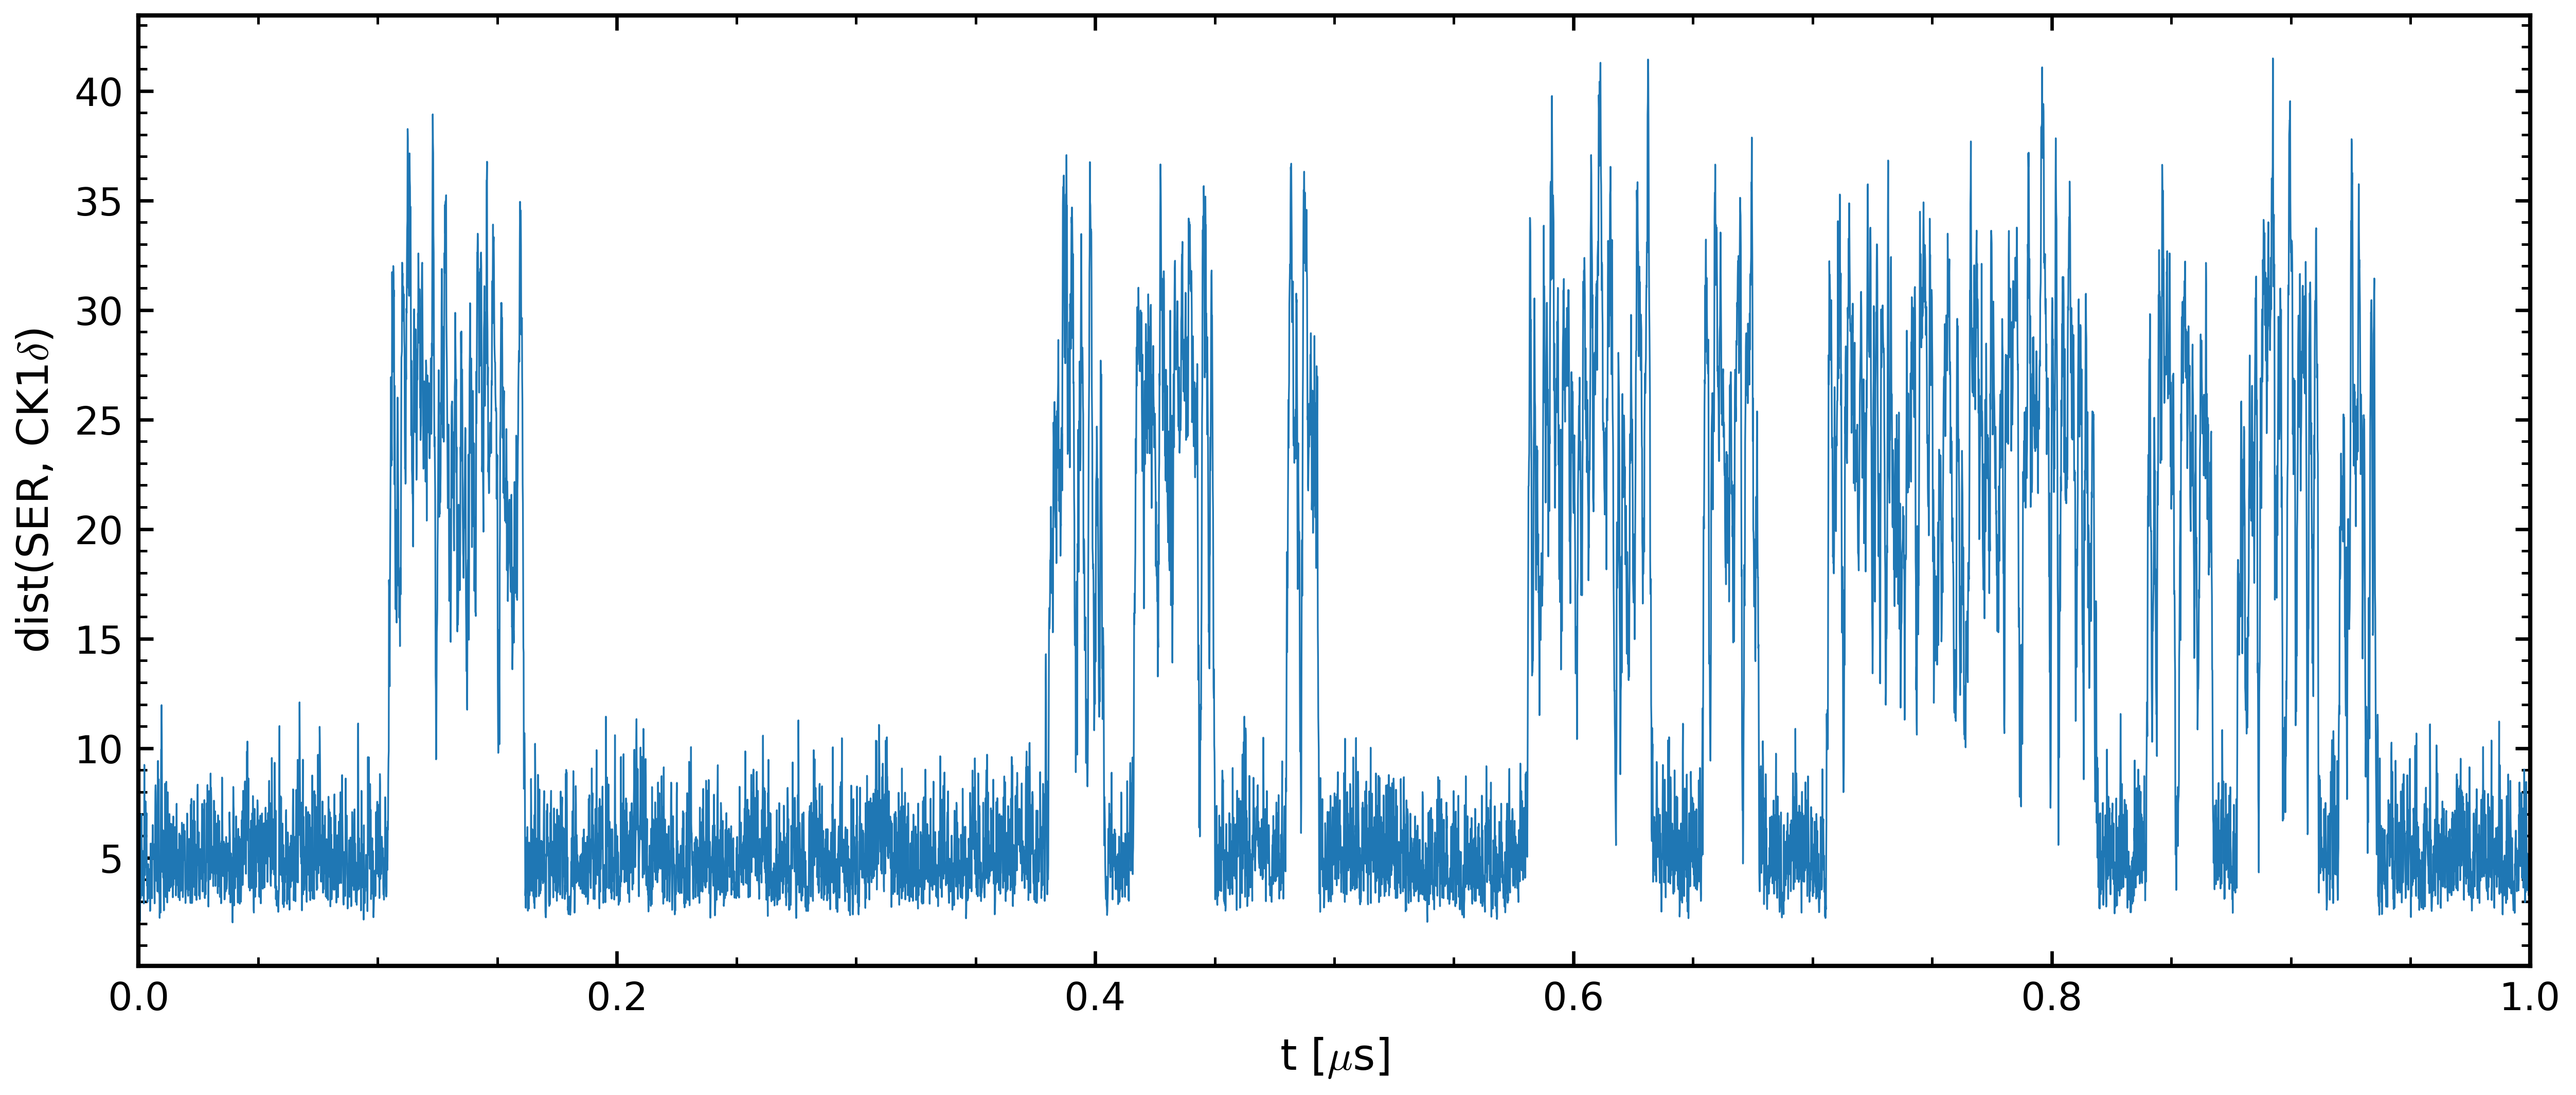

In [50]:
plot_dist(dist_ser,5,end=10000)

In [3]:
# CUDA or CPU
if torch.cuda.is_available():
        device = torch.device("cuda")
        torch.backends.cudnn.benchmark = True
        print("cuda")
else:
        device = torch.device("cpu")
        print("cpu")
torch.set_num_threads(12)

cpu


In [4]:
# MACROs
''' VAMPnet hyper-parameters '''
val_perc = 0.3
nodes = [154, 30, 2]
learn_rate = 0.5e-2
batch_sz = 40000
epochs = 50
eps_regularize = 1e-07
TLAG=5

# Dataset

### Trajectory

Load trajectory data for training

In [51]:
dist_ser = np.loadtxt(path+"sim1_no-phospho_ck1d-rigid_tdp43_dist.txt")[1000:]
dist_ser2 = np.loadtxt(path+"sim2_no-phospho_ck1d-rigid_tdp43_dist.txt")[1000:]
dist_ser = np.append(dist_ser, dist_ser2, axis=0)
dist_ser2 = np.loadtxt(path+"sim3_no-phospho_ck1d-rigid_tdp43_dist.txt")[1000:]
dist_ser = np.append(dist_ser, dist_ser2, axis=0)

In [52]:
print(dist_ser.shape)

(897000, 154)


Dataset with trajectory, split into training and validation datasets (70% and 30%)

In [12]:
dataset_ser = TrajectoryDataset(TLAG, dist_ser.astype(np.float32))

n_val_ser = int(len(dataset_ser)*val_perc)
train_data_ser, val_data_ser = torch.utils.data.random_split(dataset_ser, [len(dataset_ser) - n_val_ser, n_val_ser])


### Creating VAMPNet

VAMPnet lobe 

In [13]:
lobe = nn.Sequential(
    nn.BatchNorm1d(nodes[0]),
    nn.Linear(nodes[0], nodes[1]), nn.ELU(),
    nn.Linear(nodes[1], nodes[2]),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)
print(lobe)
lobe = lobe.to(device=device)
vampnet_ser = VAMPNet(lobe=lobe, learning_rate=learn_rate, device=device, epsilon=eps_regularize)

loader_train_ser = DataLoader(train_data_ser, batch_size=batch_sz, shuffle=True)
loader_val_ser = DataLoader(val_data_ser, batch_size=len(val_data_ser), shuffle=False)


Sequential(
  (0): BatchNorm1d(154, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=154, out_features=30, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=30, out_features=2, bias=True)
  (4): Softmax(dim=1)
)


### Training

In [14]:
model_ser = vampnet_ser.fit(loader_train_ser, n_epochs=epochs,
                        validation_loader=loader_val_ser).fetch_model()

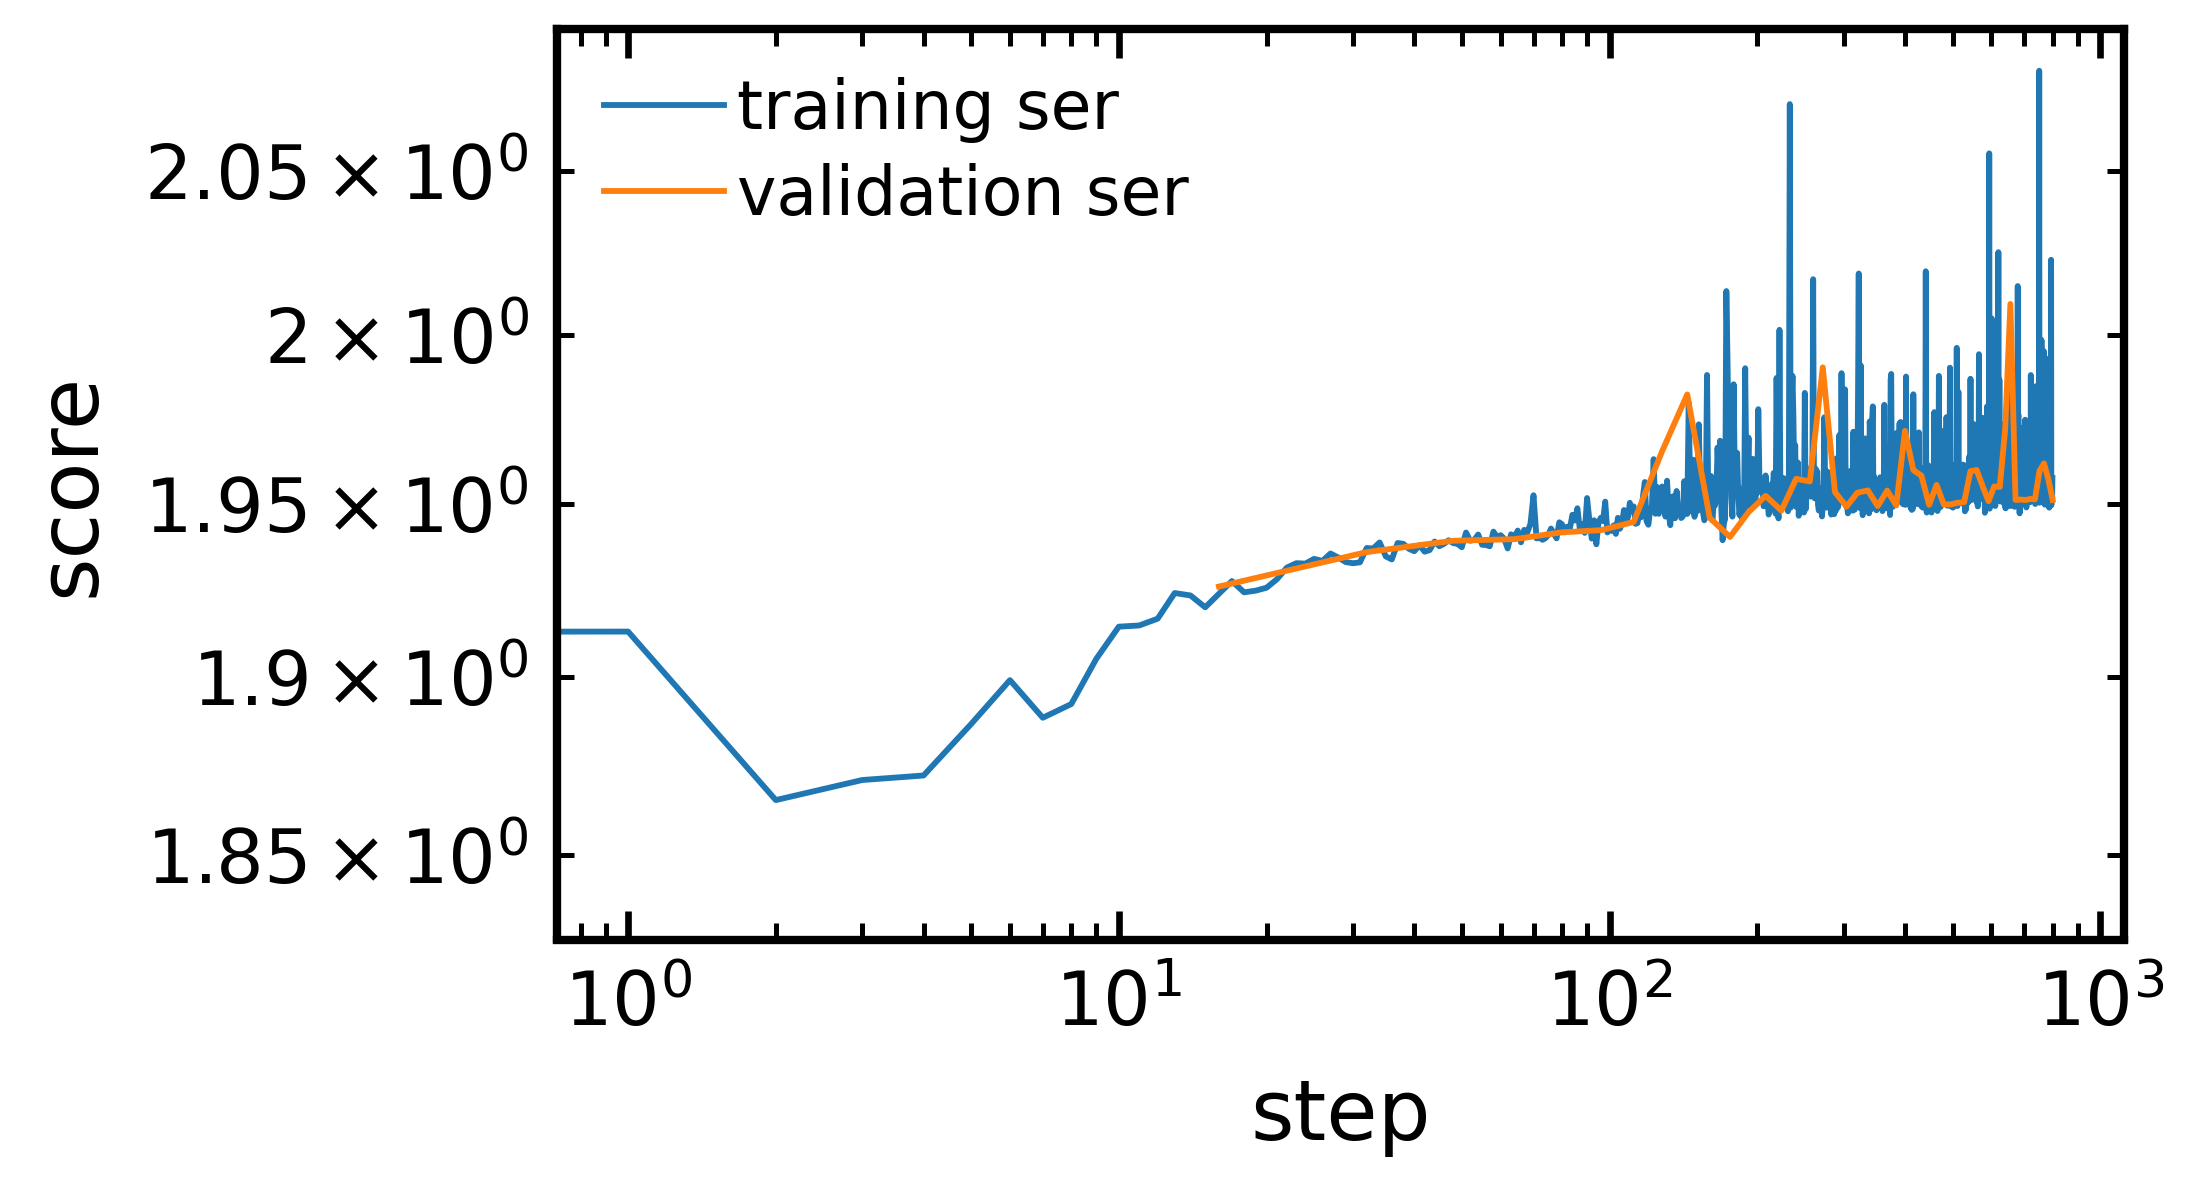

1.9576327800750732
1.9511725902557373


In [15]:
plt.loglog(*vampnet_ser.train_scores.T, label='training ser', linewidth=0.7)
plt.loglog(*vampnet_ser.validation_scores.T, label='validation ser', linewidth=0.7)
plt.xlabel('step')
plt.ylabel('score')
plt.legend()
plt.show()

print(vampnet_ser.train_scores.T[1,-1])
print(vampnet_ser.validation_scores.T[1,-1])


In [16]:
# Transform distance into percentage of being in state 0 or 1 
featser_ser = model_ser.transform(dist_ser)

# assign 0 if percentage of state 0 is over 50%, otherwise 1
assignsser_ser = featser_ser.argmax(1)
print((np.min(assignsser_ser),np.max(assignsser_ser)))


(0, 1)


### Check VAMPNet result 


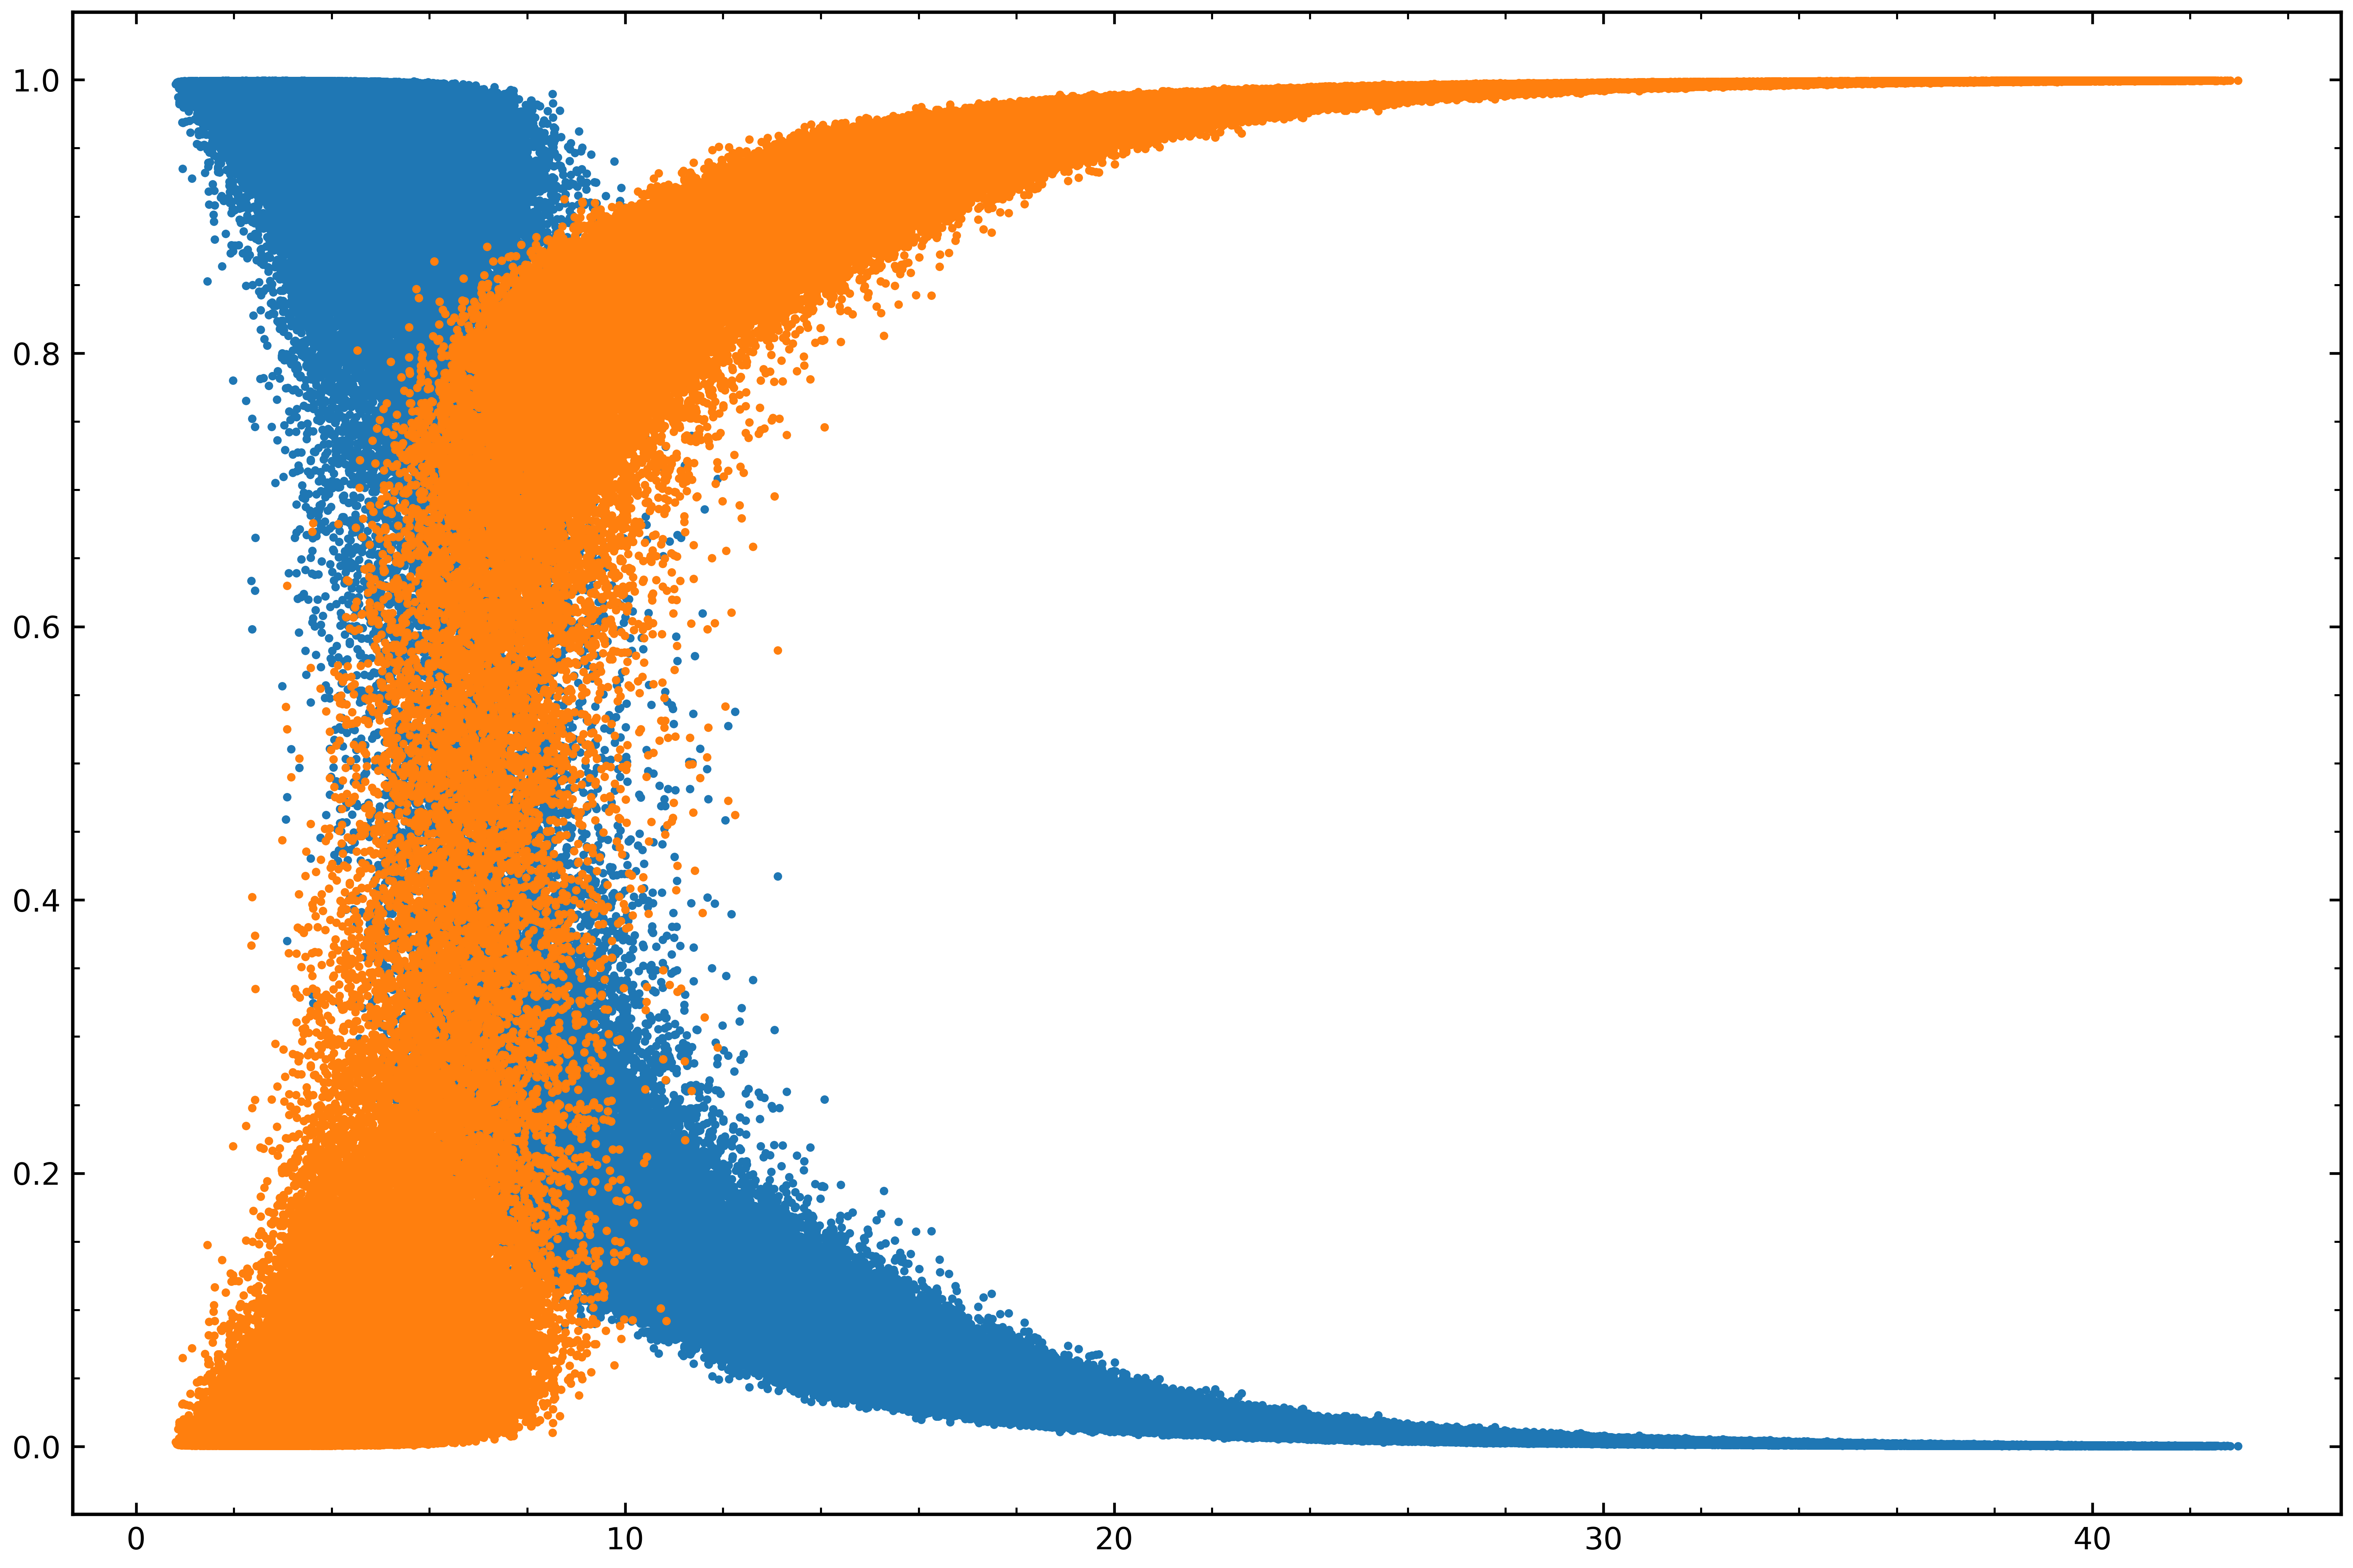

In [18]:
f, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.plot(dist_ser[:,100], featser_ser[:, 0], ".")
axes.plot(dist_ser[:,100], featser_ser[:, 1], ".")

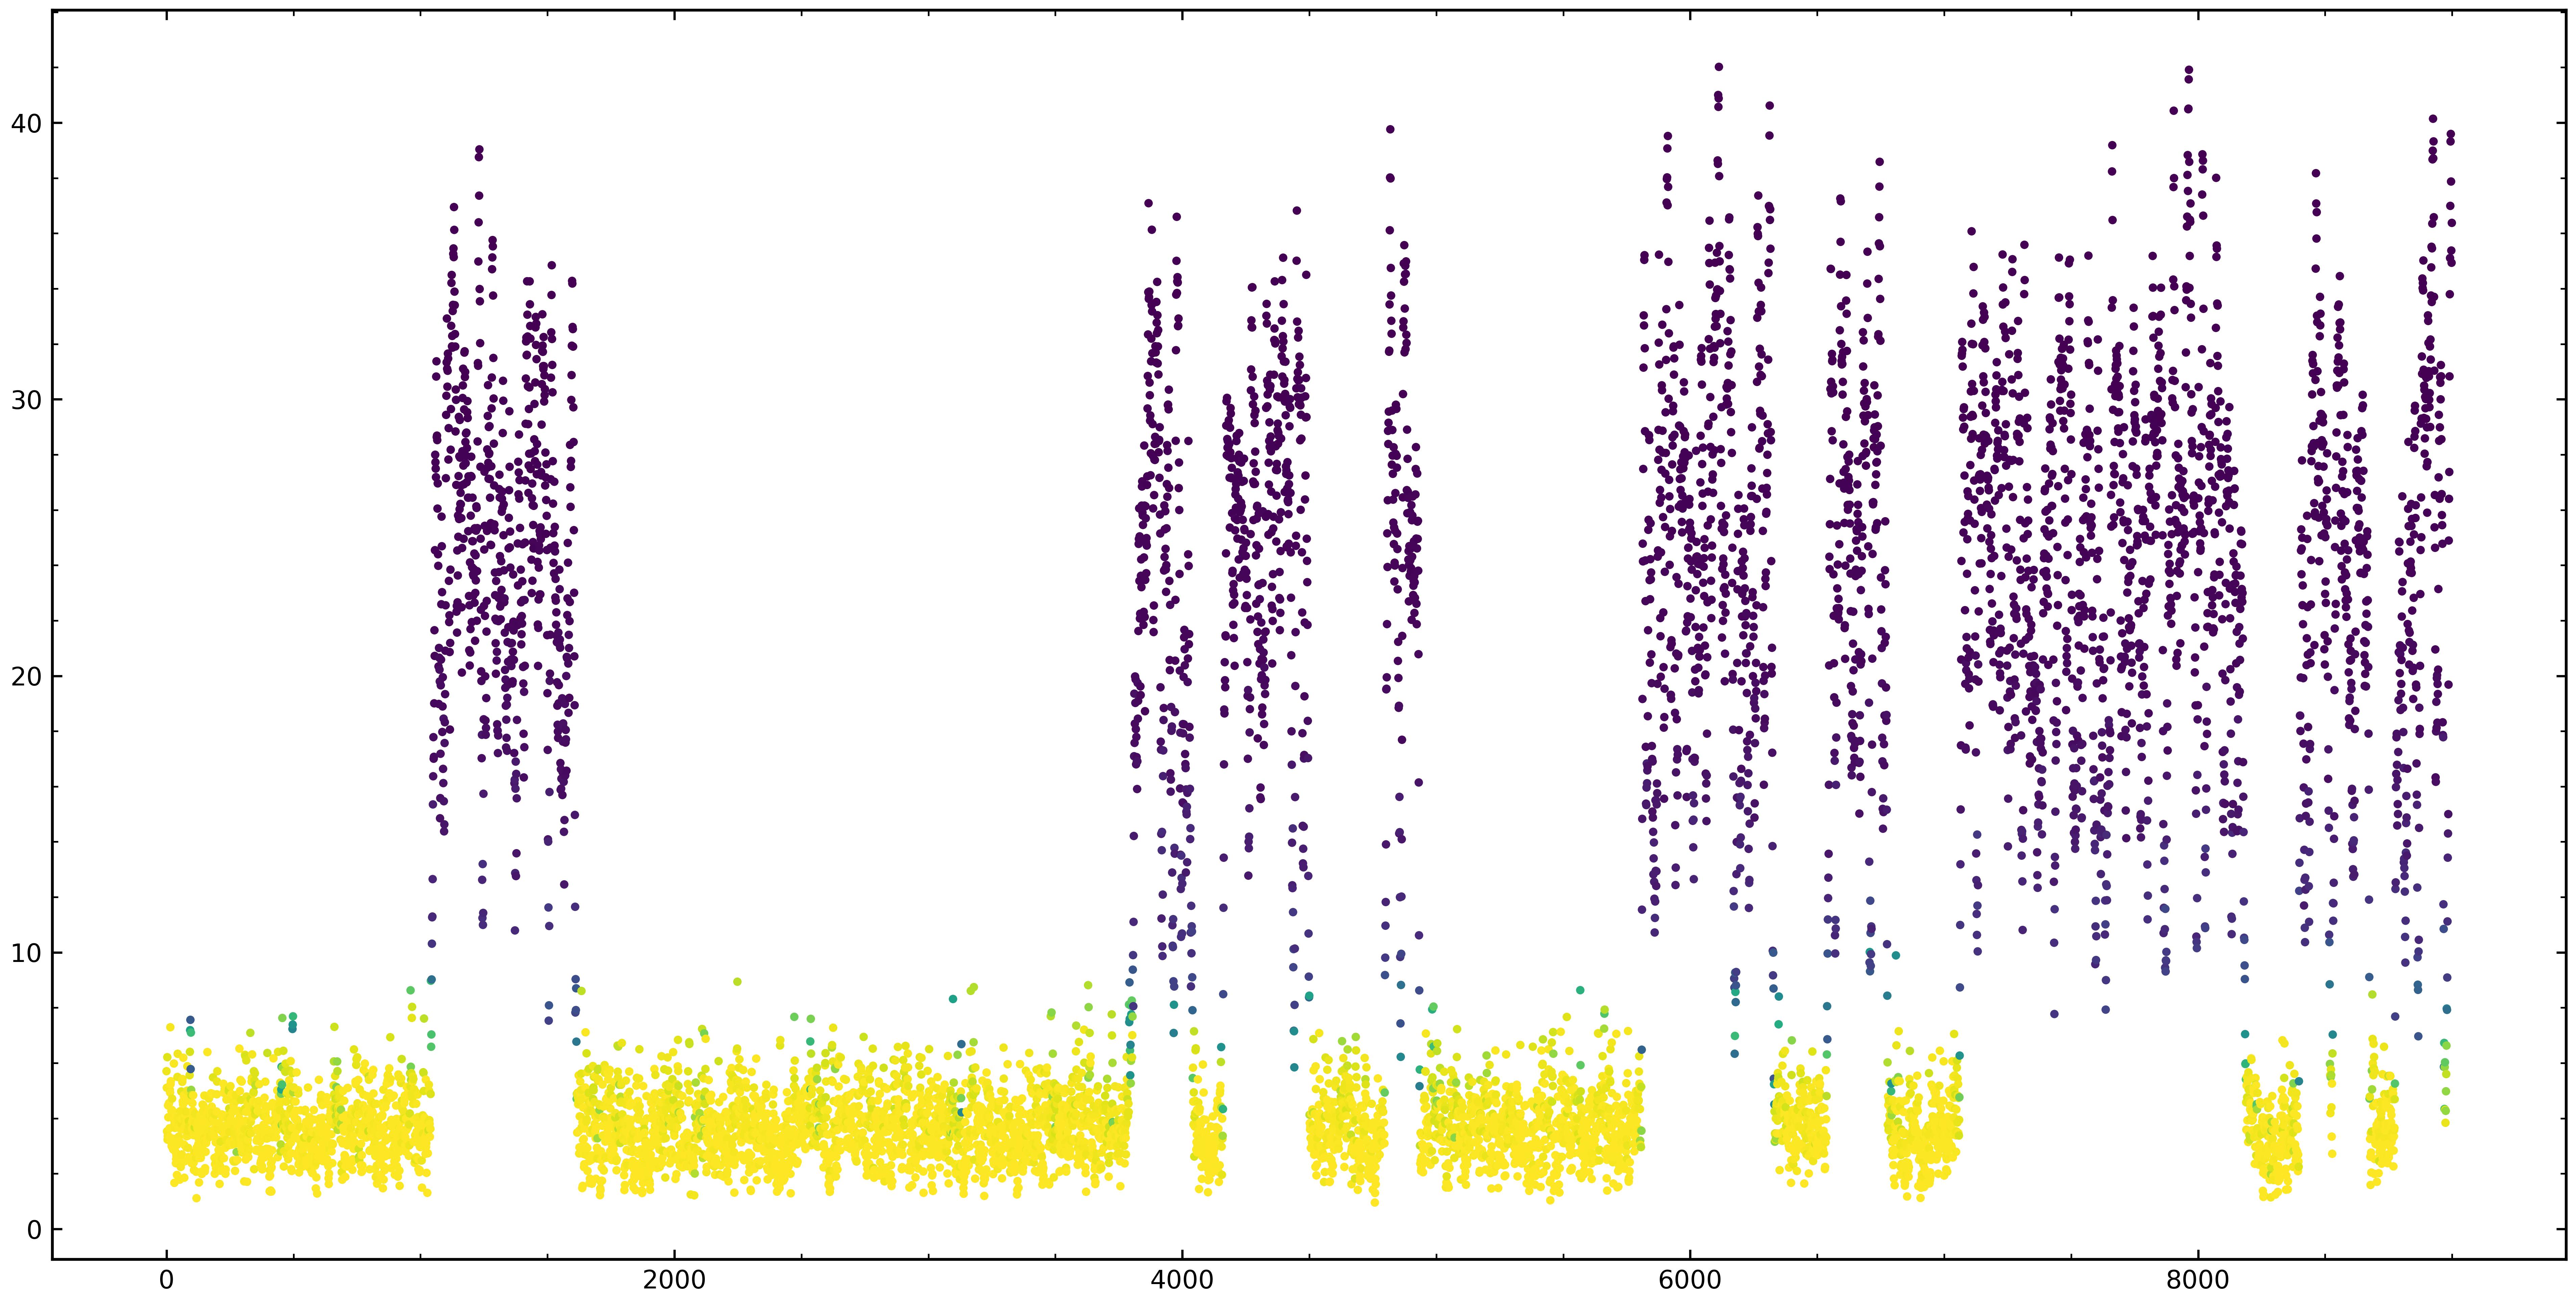

In [19]:
f, axes = plt.subplots(1, 1, figsize=(16, 8))
axes.scatter(np.arange(len(dist_ser[:9000])), dist_ser[:9000,100], c=featser_ser[:9000,0], s=4)

In [20]:
vamp_estimator = VAMP(lagtime=TLAG, observable_transform=model_ser)
vamp = vamp_estimator.fit(dist_ser.astype(np.float32)).fetch_model()
print(f"VAMP-2 score under lag {TLAG}: s = {vamp.score(2).round(2)}")

VAMP-2 score under lag 5: s = 1.95


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.93s/it]


Text(0, 0.5, 'timescale')

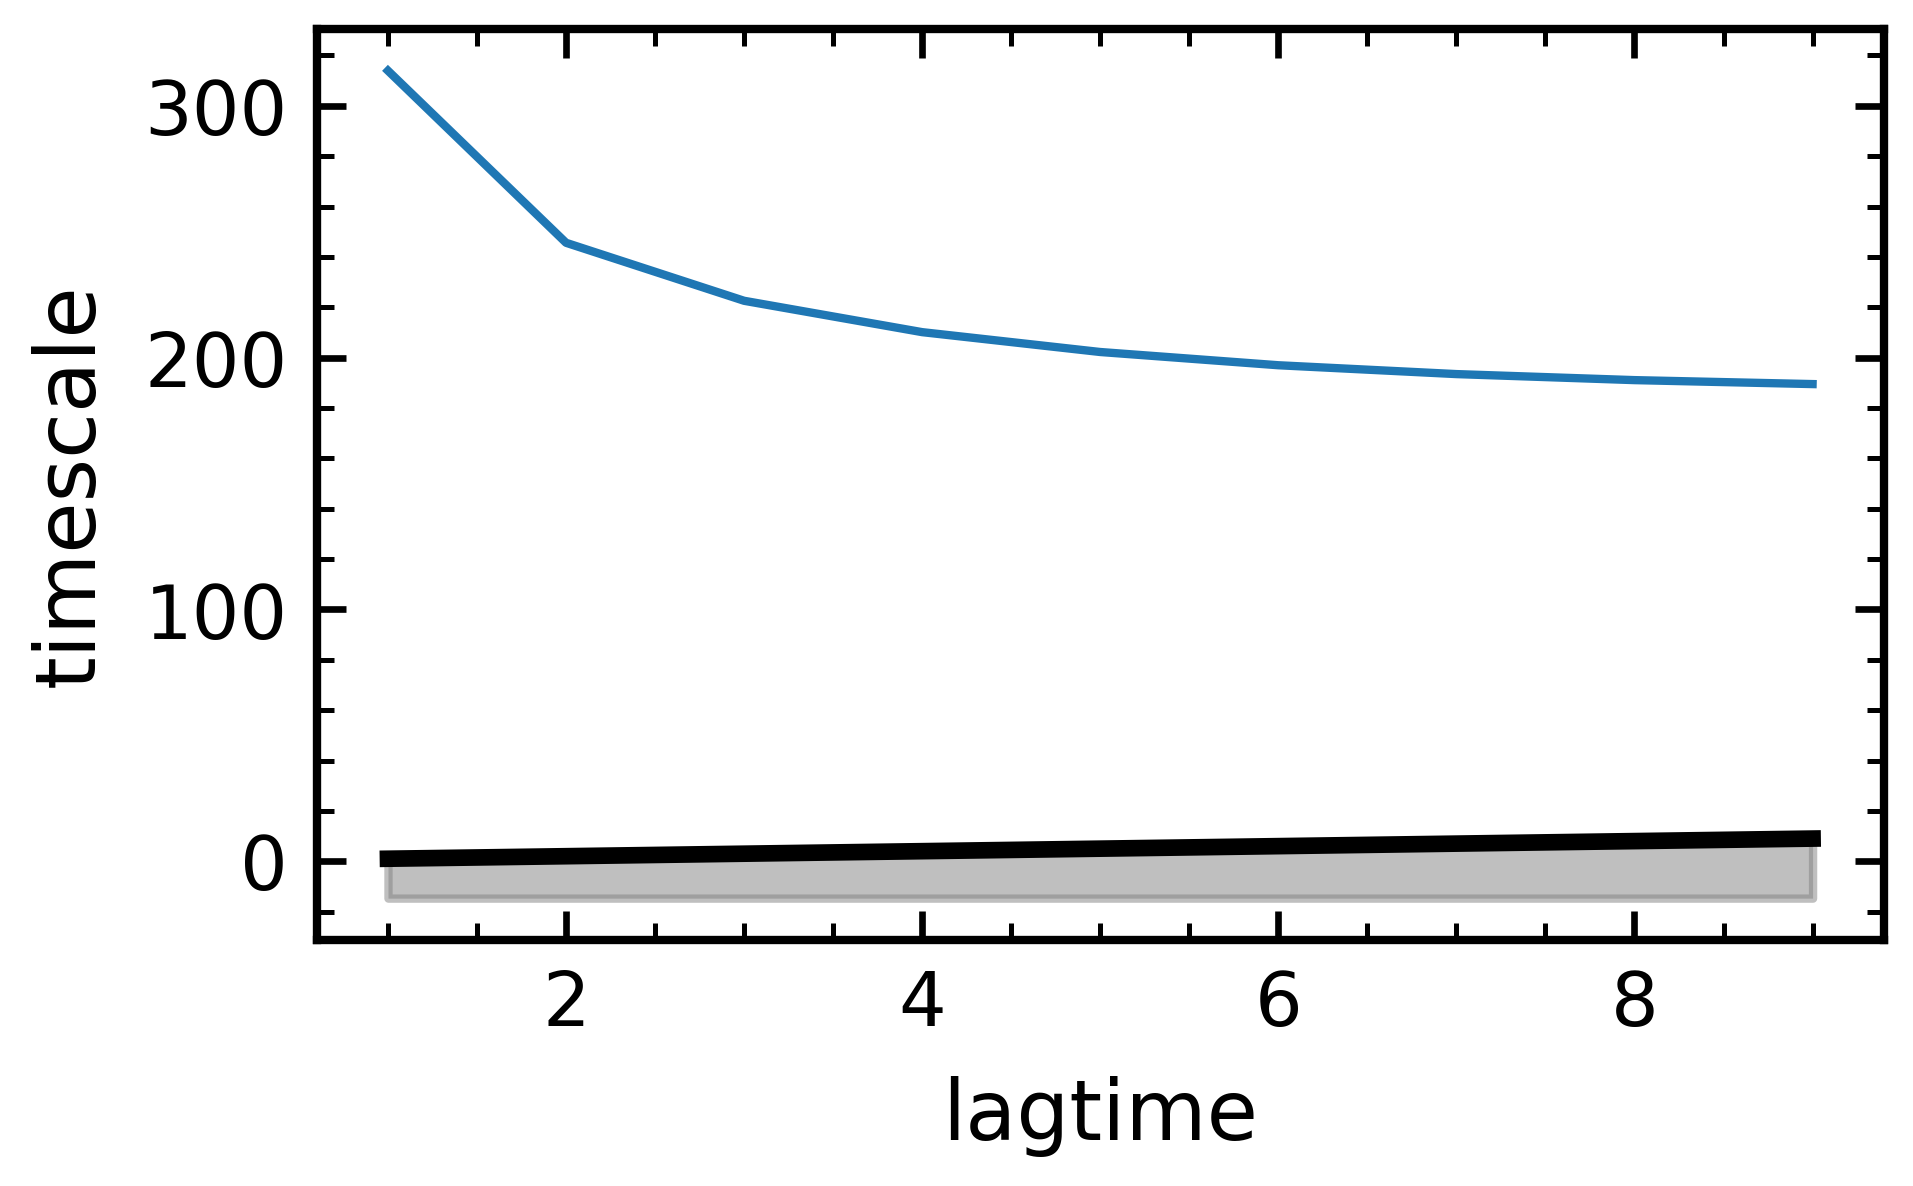

In [21]:
lagtimes = np.arange(1, 10, dtype=np.int32)
vamp_models = [VAMP(lagtime=lag, observable_transform=model_ser).fit_fetch(dist_ser.astype(np.float32)) for lag in tqdm(lagtimes)]

ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')

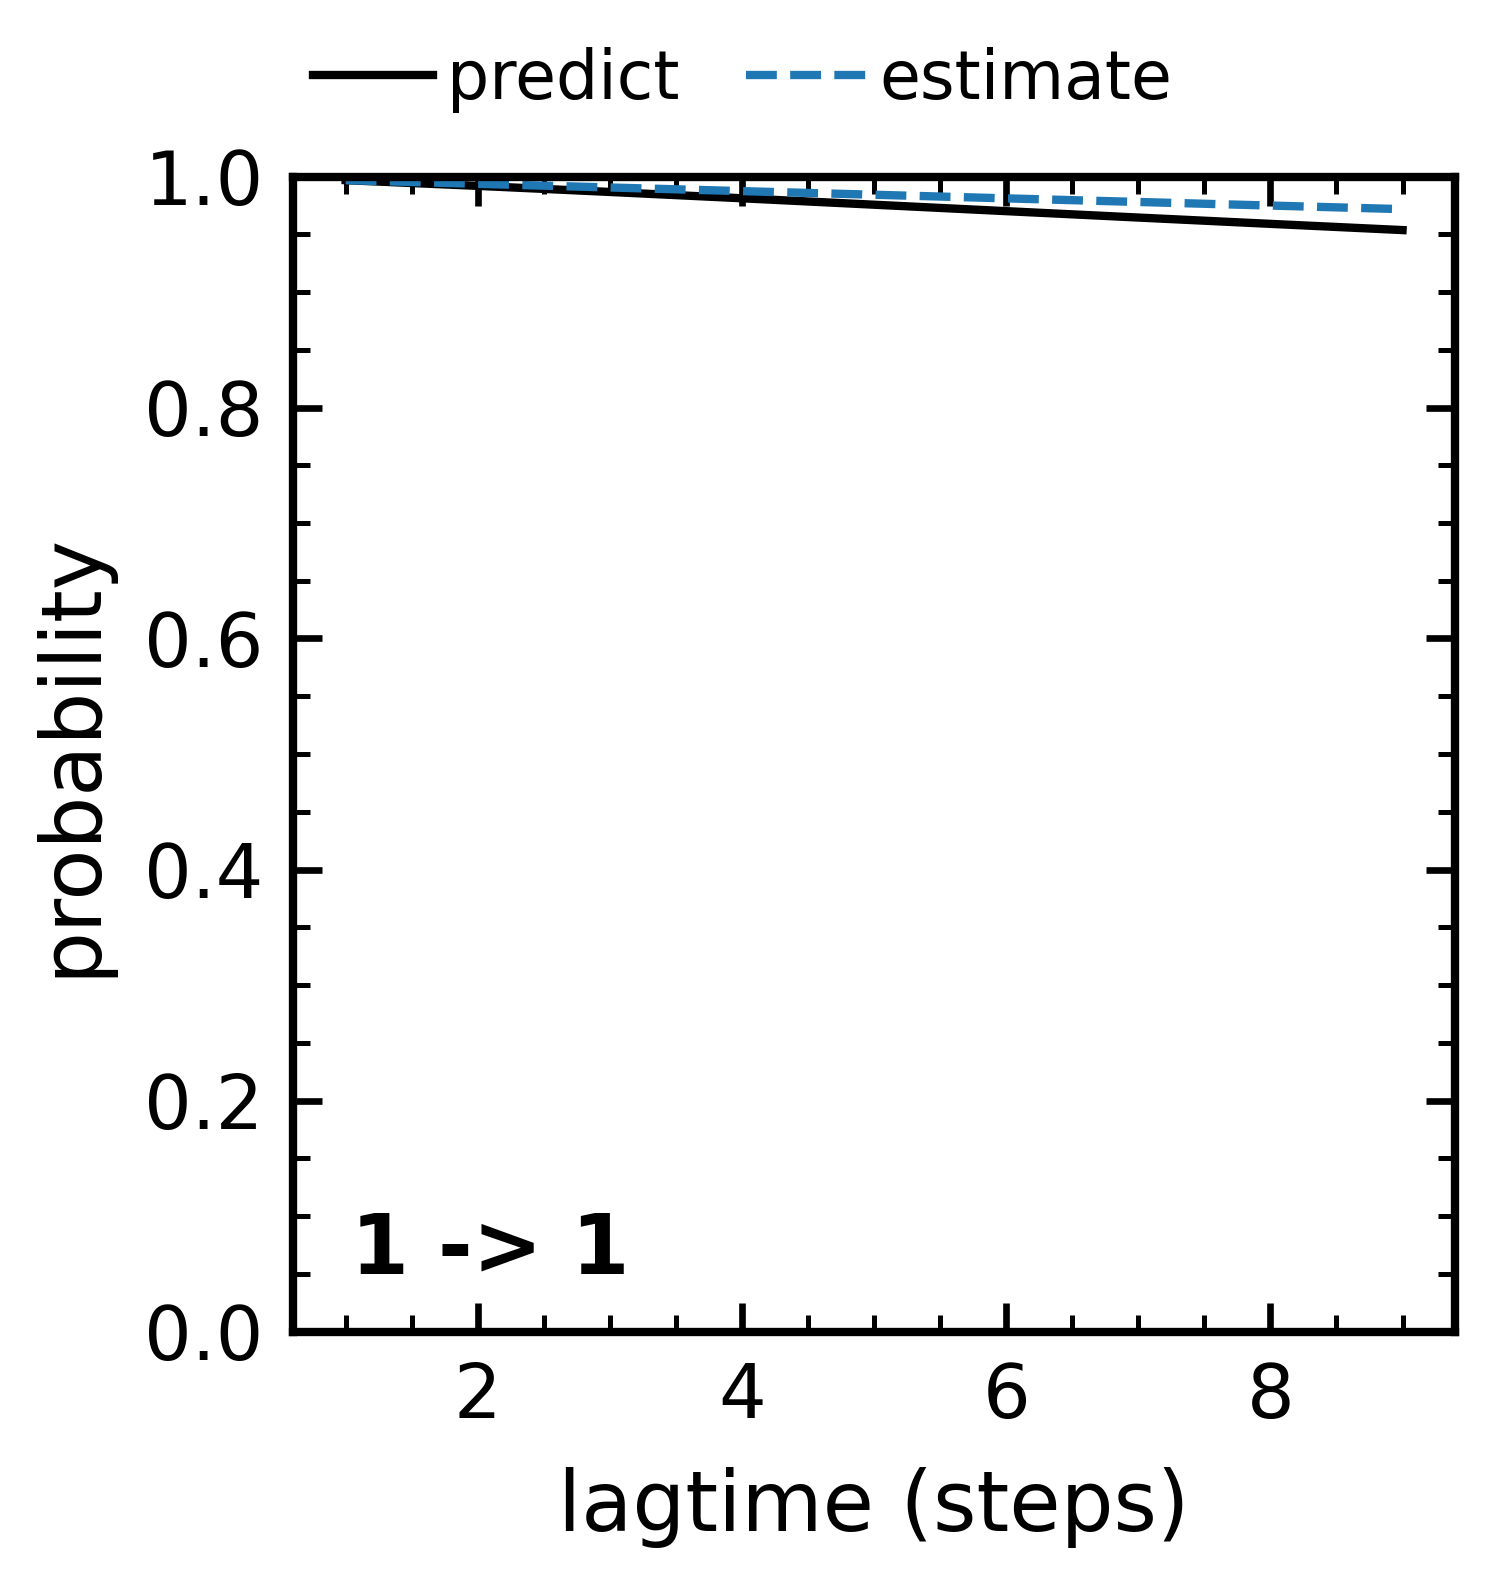

In [22]:
plot_ck_test(vamp_models[0].ck_test(vamp_models));


## Transform trajectory

In [31]:
def inserting_tps_state(dtraj, prob_traj, min_prob, max_prob=None, tps_state_num=None):
    ''' 
    Add intermediate state between bound and unbound when probability of being in one state is between min_prob and 1-min_prob.
    '''
    if max_prob==None:
        max_prob = 1 - min_prob
    if tps_state_num==None:
        tps_state_num = np.max(dtraj)+1
    
    mask = (prob_traj < max_prob) & (prob_traj > min_prob)
    tps_dtrajs = np.where(mask, tps_state_num, dtraj)
    return tps_dtrajs


Transform simulation trajectory into discrete trajectory of bound/unbound state

In [53]:
path1=f"/localscratch/zippoema/md_data/simple-ness/"

In [26]:
# Select NESS simulation
dmu = -5
n_ser = 10

In [54]:
dist = np.loadtxt(path1+f"sim_ser{n_ser}/sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_dist.txt")

print(len(dist))

feat_ser = model_ser.transform(dist)

print(feat_ser[0], dist[0][0])

195000
[0.93869346 0.06130651] 5.69167807776919


In [32]:
assigns_ser = inserting_tps_state(feat_ser.argmax(1), feat_ser[:,0], 0.3)

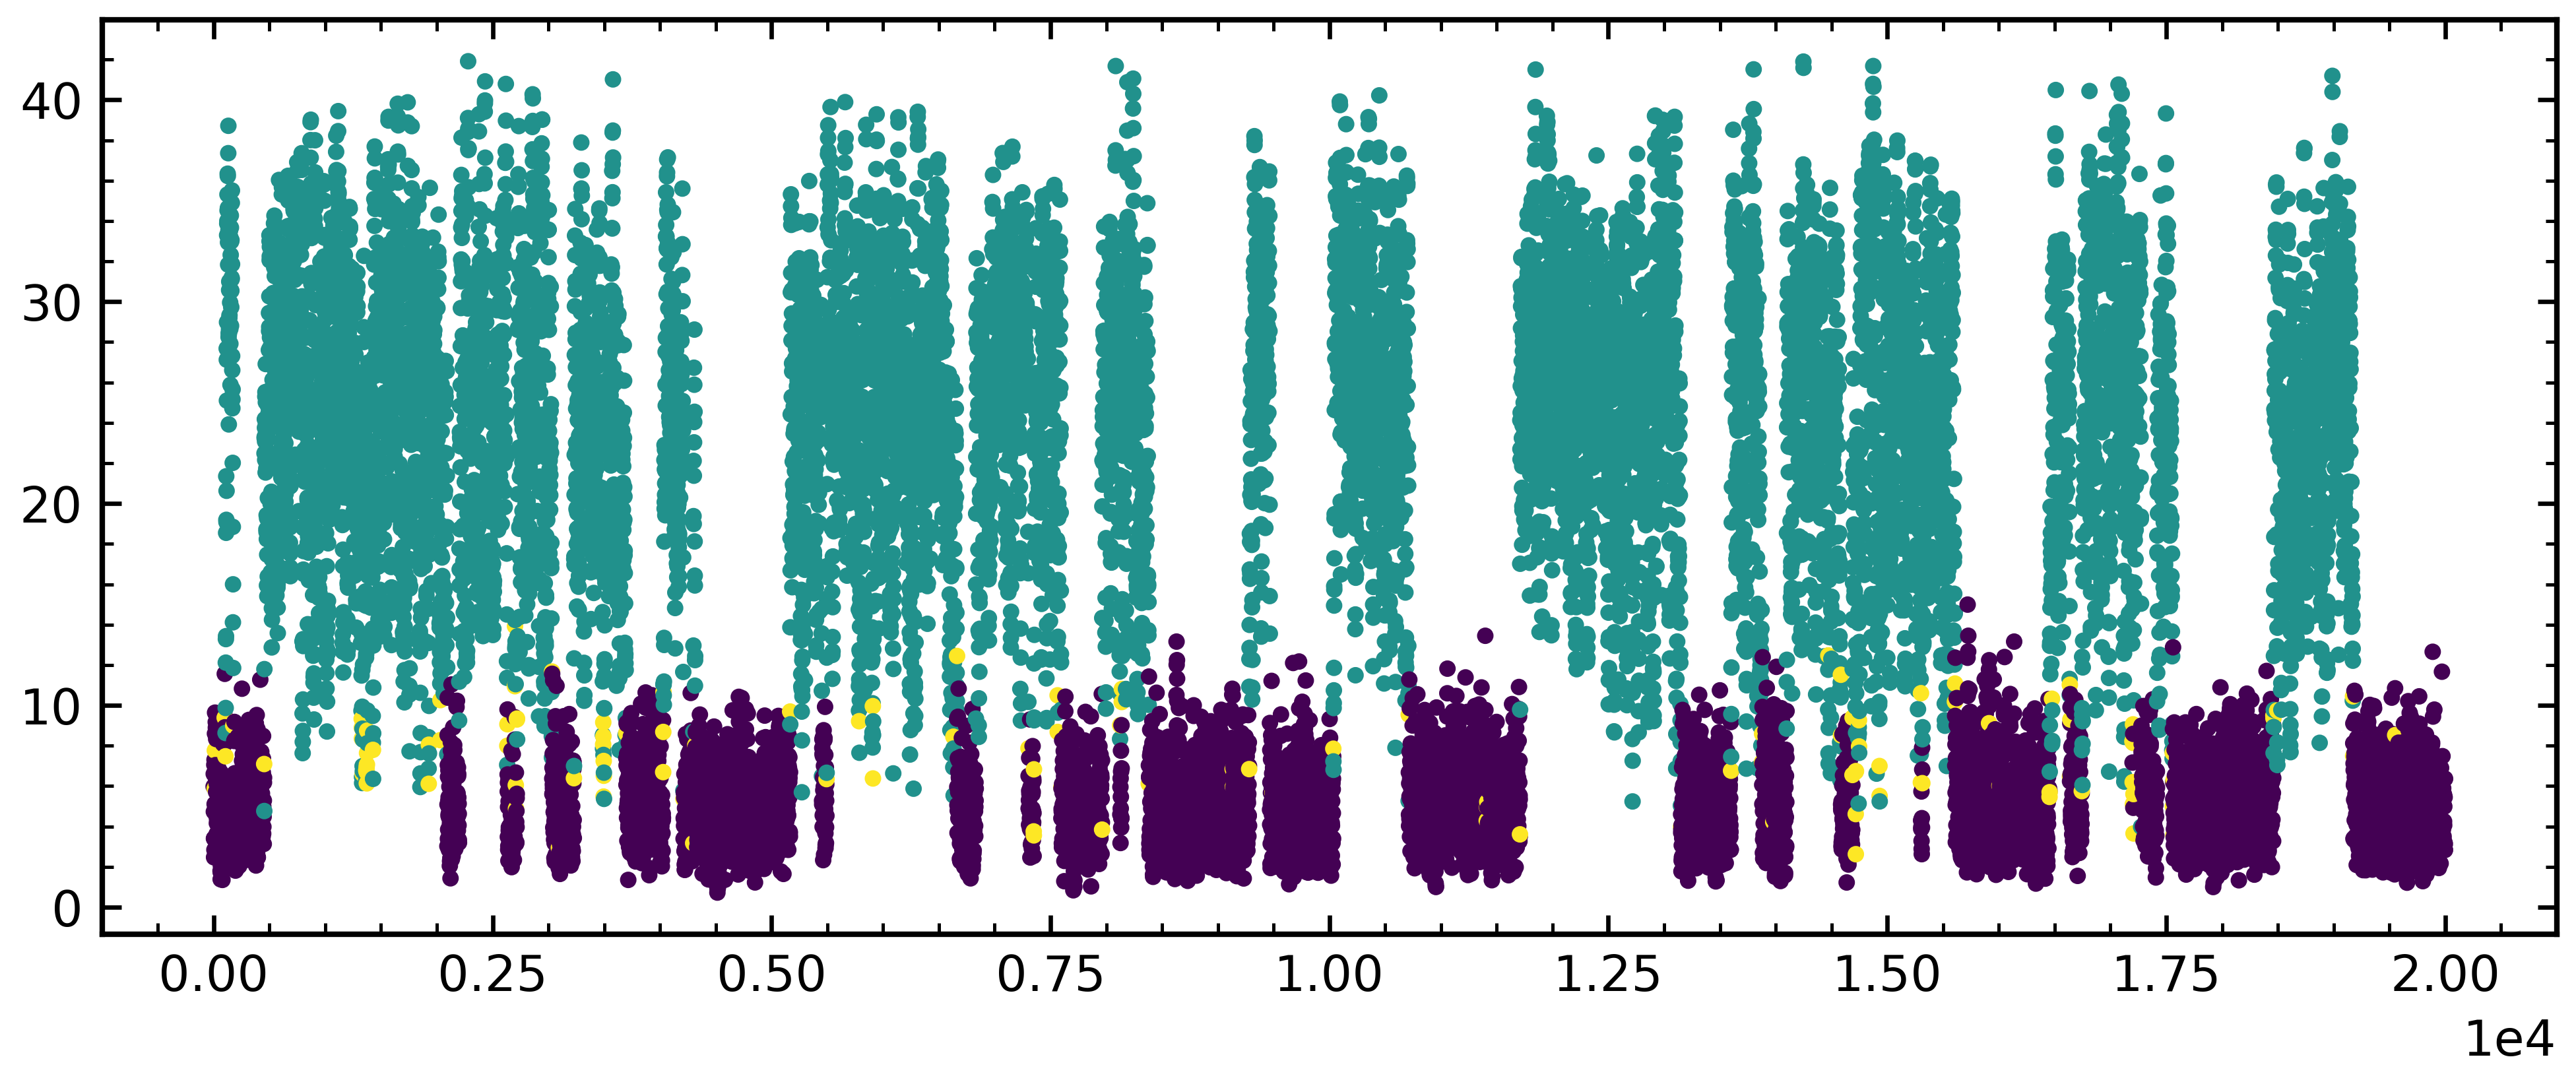

In [38]:
f, axes = plt.subplots(1, 1, figsize=(8, 3))

axes.scatter(np.arange(len(dist[:20000,1])), dist[:20000,1], c=assigns_ser[:20000], s=4)
plt.show()

In [55]:
# Filter out intermediate state using Transition-based analysis
filtered_dtraj = tba.transition_filter_state_trj(assigns_ser, tps_state_num=2).astype("bool")

print(filtered_dtraj[0], dist[0][0])

False 5.69167807776919


In [56]:
# if state 0 of VAMPnet is bound, swap state 1 and state 0
filtered_dtraj = ~filtered_dtraj

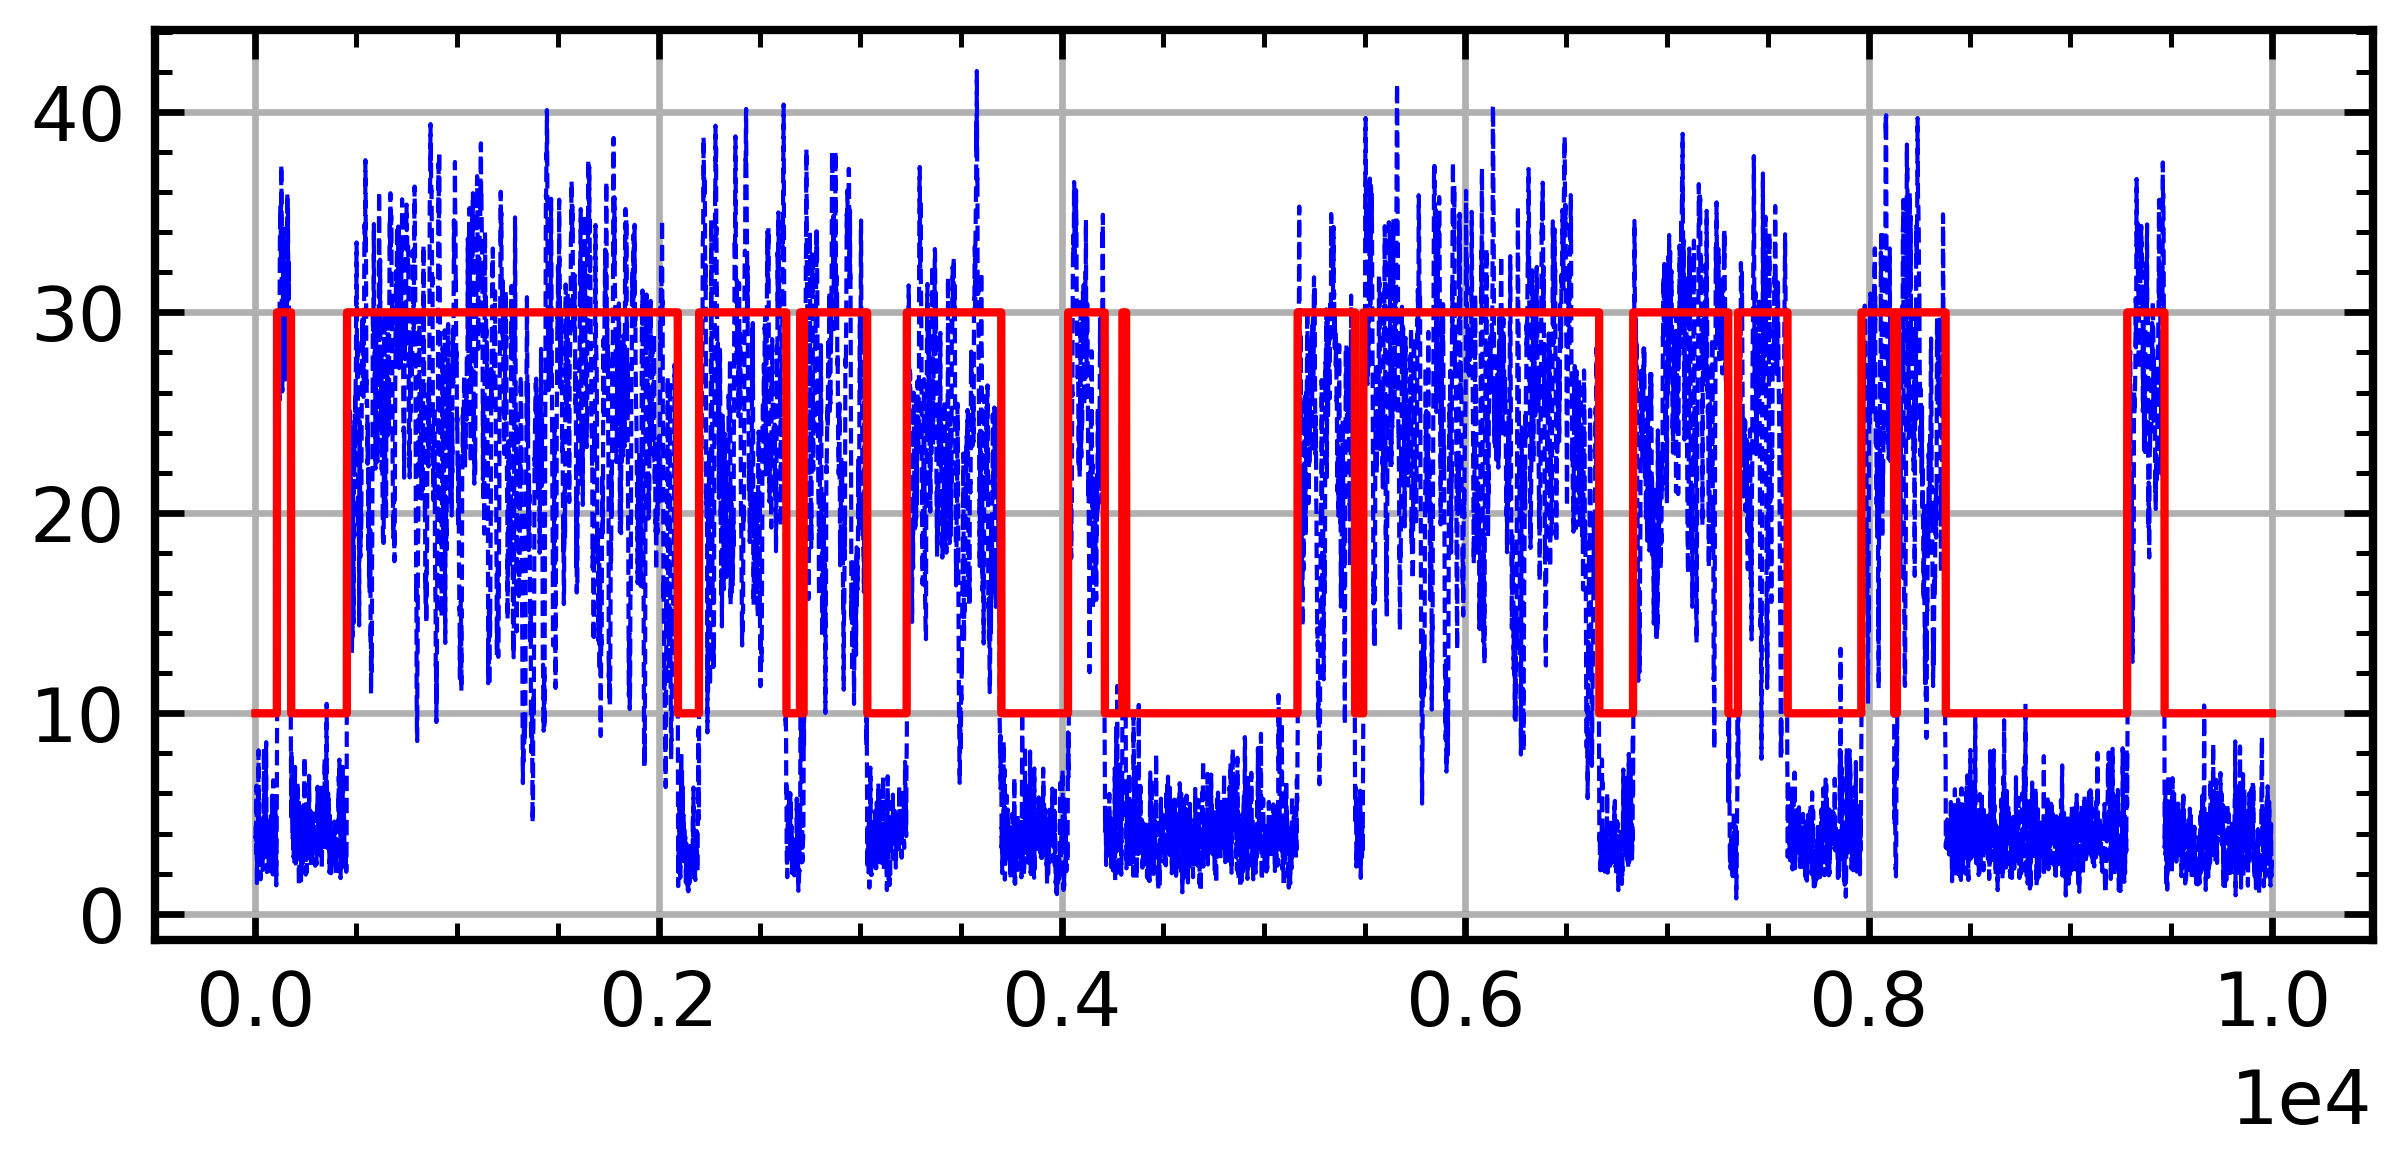

In [57]:
plt.figure(figsize=(4.77,1.97))
plt.plot(dist[0:10000,140], '--b', linewidth=0.5)
plt.plot(20*~filtered_dtraj[0:10000]+10, 'r')
plt.grid()
plt.show()

In [39]:
#np.savetxt(path1+f"sim_ser{n_ser}/sim-ser{n_ser}_mu{dmu}_ck1d-rigid_tdp43_boundtraj.txt", filtered_dtraj)